In [1]:
import pandas as pd
import numpy as np
import torch
from scipy.stats import gamma, norm
from darts.models import RNNModel,RegressionModel , RandomForest, XGBModel
import pywt
from darts import TimeSeries
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import json
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL
from sklearn.ensemble import IsolationForest
import os

# Set random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


c:\Users\varas\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm



Read and preprocess the input data


In [2]:

def fit_gamma(precip: pd.Series) -> tuple:
    non_zero = precip[precip > 0]
    if len(non_zero) == 0:
        return np.nan, np.nan, 1.0
    shape, _, scale = gamma.fit(non_zero, floc=0)
    zero_prob = (precip == 0).mean()
    return shape, scale, zero_prob


def compute_spi(roll: pd.Series, shape: float, scale: float, zero_prob: float) -> np.ndarray:
    # probs = zero_prob + (1 - zero_prob) * gamma.cdf(roll, shape, scale=scale)
    probs = np.where(
    roll.isna(),
    np.nan,
    zero_prob + (1 - zero_prob) * gamma.cdf(roll, shape, scale=scale)
    )
    probs = np.clip(probs, 1e-10, 1 - 1e-10)
    return norm.ppf(probs)


def process_station(df_station: pd.DataFrame) -> pd.DataFrame:
    df_station = df_station.sort_values('ds').reset_index(drop=True)
    # shape, scale, zero_prob = fit_gamma(df_station['precip'])
    result = {'ds': df_station['ds']}

    for s in [1, 3, 6, 9, 12, 24]:
        roll = df_station['precip'].rolling(s, min_periods=s).sum()
        shape, scale, zero_prob = fit_gamma(roll.dropna())

        spi = compute_spi(roll, shape, scale, zero_prob)
        # z-score manually
        mean, std = np.nanmean(spi), np.nanstd(spi)
        result[f'SPI_{s}'] = (spi - mean) / std

    result_df = pd.DataFrame(result)
    result_df['station_id'] = df_station['station_id'].iloc[0]
    return result_df


# Load & aggregate to monthly totals
df = (
    pd.read_csv('../result/merged_data.csv', parse_dates=['data'])
      .assign(ds=lambda d: d['data'].dt.to_period('M').dt.to_timestamp())
      .groupby(['station_id', 'ds'])['rrr24']
      .sum()
      .reset_index(name='precip')
)

# Compute SPI for each station
spi_list = [process_station(g) for _, g in df.groupby('station_id')]
all_spi = pd.concat(spi_list, ignore_index=True)


C:\Users\varas\AppData\Local\Temp\ipykernel_5196\4171478131.py:42: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pd.read_csv('../result/merged_data.csv', parse_dates=['data'])


class TaylorDiagram

In [3]:

class TaylorDiagram:
    def __init__(self, ref_std, fig=None, rect=111, label='Reference'):
        self.ref_std = ref_std

        self.fig = fig if fig is not None else plt.figure()
        self.ax = self.fig.add_subplot(rect, polar=True)
        self.ax.set_theta_direction(-1)
        self.ax.set_theta_offset(np.pi / 2)

        self.sample_points = []

        # Set up axis
        self.ax.set_thetamin(0)
        self.ax.set_thetamax(90)
        self.ax.set_ylim(0, 1.5 * ref_std)

        # Set up correlation grid
        self._setup_axes()

        # Reference point
        self.ax.plot([0], [ref_std], 'k*', markersize=10, label=label)

    def _setup_axes(self):
        corrs = np.array([0.0, 0.2, 0.4, 0.6, 0.8, 0.9, 0.95, 0.99, 1.0])
        angles = np.arccos(corrs)
        self.ax.set_thetagrids(np.degrees(angles), labels=[f"{c:.2f}" for c in corrs])
        self.ax.set_ylabel('Standard Deviation')

    def add_sample(self, stddev, corrcoef, label, marker='o'):
        theta = np.arccos(corrcoef)
        point = self.ax.plot(theta, stddev, marker, label=label)
        self.sample_points.append(point)

    def add_contours(self, levels=5, **kwargs):
        rs, ts = np.meshgrid(
            np.linspace(0, self.ax.get_ylim()[1]),
            np.linspace(0, np.pi / 2)
        )
        rms = np.sqrt(
            self.ref_std**2 + rs**2 - 2 * self.ref_std * rs * np.cos(ts)
        )
        contours = self.ax.contour(ts, rs, rms, levels=levels, **kwargs)
        return contours
    
def plot_spi_trend(historical: TimeSeries, forecast: TimeSeries, title='SPI Trend'):
    full_series = historical.append(forecast)

    plt.figure(figsize=(12, 4))
    full_series.plot(label="SPI")
    plt.axvline(x=historical.end_time(), color='r', linestyle='--', label="Forecast Start")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("SPI")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()


Define Models and train


In [ ]:

class WBBLSTMModel:
    def __init__(self, wavelet='db1', level=1, **lstm_kwargs):
        self.wavelet = wavelet
        self.level = level
        self.lstm_kwargs = lstm_kwargs
        self.lstm_model = RNNModel(model='LSTM', **lstm_kwargs)
        
    def wavelet_decompose(self, series: TimeSeries):
        coeffs = pywt.wavedec(series.values().flatten(), self.wavelet, level=self.level)
        return coeffs
    
    def wavelet_reconstruct(self, coeffs):
        return pywt.waverec(coeffs, self.wavelet)
    
    def fit(self, series: TimeSeries):
        # Decompose
        coeffs = self.wavelet_decompose(series)
        approx = coeffs[0]  # Use approximation coeffs as input to LSTM
        approx_series = TimeSeries.from_values(approx.reshape(-1, 1))
        
        # Fit the internal LSTM model
        self.lstm_model.fit(approx_series)

    def predict(self, n,series):
        pred = self.lstm_model.predict(n)
        return pred
    def save(self, path):
        # os.makedirs(path, exist_ok=True)

        # Save LSTM model
        self.lstm_model.save(path)

        # Save wavelet settings and kwargs
        meta = {
            'wavelet': self.wavelet,
            'level': self.level,
            'lstm_kwargs': self.lstm_kwargs
        }

        with open(os.path.join(os.path.dirname(path), "WBILSTMmeta.json"), "w") as f:
            json.dump(meta, f)

    @classmethod
    def load(cls, path):
        with open(os.path.join(os.path.dirname(path), "WBILSTMmeta.json"), "r") as f:
            meta = json.load(f)


        wavelet = meta['wavelet']
        level = meta['level']
        lstm_kwargs = meta['lstm_kwargs']
        instance = cls(wavelet=wavelet, level=level, **lstm_kwargs)

        # instance = cls(**meta)
        instance.lstm_model = RNNModel.load(path)
        return instance



window_size = 12
num_epochs=300
model_constructors = {
    'LSTM'      : lambda: RNNModel(model='LSTM', input_chunk_length=window_size, output_chunk_length=6,
                                   hidden_dim=25, n_rnn_layers=2, dropout=0.1,
                                   batch_size=16, n_epochs=num_epochs, optimizer_kwargs={'lr':1e-3},
                                   random_state=SEED)
                                   ,
    'SVR'       : lambda: RegressionModel(model=SVR(kernel='rbf'),lags=window_size),
    'RandomRF'  : lambda: RandomForest(lags=window_size, n_estimators=100, random_state=SEED),
    'ExtraTF'   : lambda: XGBModel(lags=window_size, objective='reg:squarederror', random_state=SEED),
    'WBBLSTM'   : lambda: WBBLSTMModel(
        wavelet='db1',
        level=1,
        input_chunk_length=12,
        output_chunk_length=6,
        hidden_dim=25,
        n_rnn_layers=2,
        dropout=0.1,
        batch_size=16,
        n_epochs=num_epochs,
        optimizer_kwargs={'lr':1e-3},
        random_state=SEED
    )
}


def compute_metrics(obs: np.ndarray, pred: np.ndarray):
    rmse = np.sqrt(mean_squared_error(obs, pred))
    std_obs, std_pred = np.std(obs), np.std(pred)
    corr = np.corrcoef(obs, pred)[0,1]
    return std_obs, std_pred, corr, rmse

results = {}  
base_dir = "all_results2"
os.makedirs(base_dir, exist_ok=True)



for station_id, group in all_spi.groupby('station_id'):
    results[station_id] = {}
    if station_id !=40708:
             continue
    for col in [c for c in group.columns if c.startswith("SPI_")]:
        if col != "SPI_3":
            continue
        print(f"\n=== Station {station_id} | {col} ===")
        sub_df = group[['ds', col]].dropna()

        series = TimeSeries.from_dataframe(sub_df, time_col='ds', value_cols=col)
        
        # split once per series
        train, val = series.split_before(0.8)

        

        # model_folder = os.path.join(base_dir, "{station_id}/{col}")
        model_folder = os.path.join(base_dir, f"{station_id}/{col}")

        os.makedirs(model_folder, exist_ok=True)





        model_stats = {}
        forecasts = {}
        for name, mk in model_constructors.items():
            model_path = os.path.join(model_folder, name)
            if os.path.exists(model_path):
                print(f"Model {name} already trained. Skipping.")
                model_class = {
                    'LSTM': RNNModel,
                    'SVR': RegressionModel,
                    'RandomRF': RandomForest,
                    'ExtraTF': XGBModel,
                    'WBBLSTM': WBBLSTMModel
                }[name]
                print(f"Loading {name} model from {model_path}…")
                model = model_class.load(model_path)

            else:
                print(f" Training {name}…", end='')
                model = mk()

                model.fit(series)
                model.save(model_path)

                print(" saved.")


            forecast = model.predict(len(val), series=train)
            o = val.values().flatten()
            p = forecast.values().flatten()
            std_o, std_p, corr, rmse = compute_metrics(o, p)
            model_stats[name] = (std_o, std_p, corr, rmse)
            forecasts[name] = forecast

        results[station_id][col] = model_stats





=== Station 40708 | SPI_3 ===
byby


Loop over stations & timescales, 
 forecast

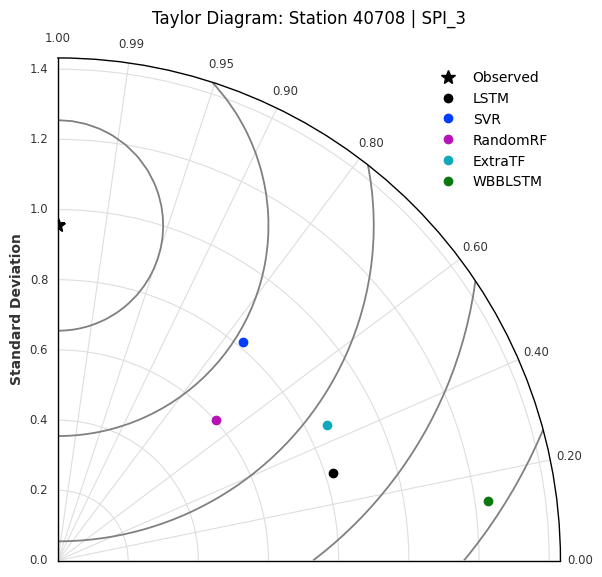

ignoring user defined `output_chunk_length`. RNNModel uses a fixed `output_chunk_length=1`.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Best model for 40708 | SPI_3: LSTM



  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 8.0 K  | train
6 | V               | Linear           | 26     | train
-------------------------------------------------------------
8.0 K     Trainable params
0         Non-trainable params
8.0 K     Total params
0.032     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 48.57it/s, train_loss=0.0527]

`Trainer.fit` stopped: `max_epochs=300` reached.


Epoch 299: 100%|██████████| 25/25 [00:00<00:00, 48.57it/s, train_loss=0.0527]


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00,  4.07it/s]


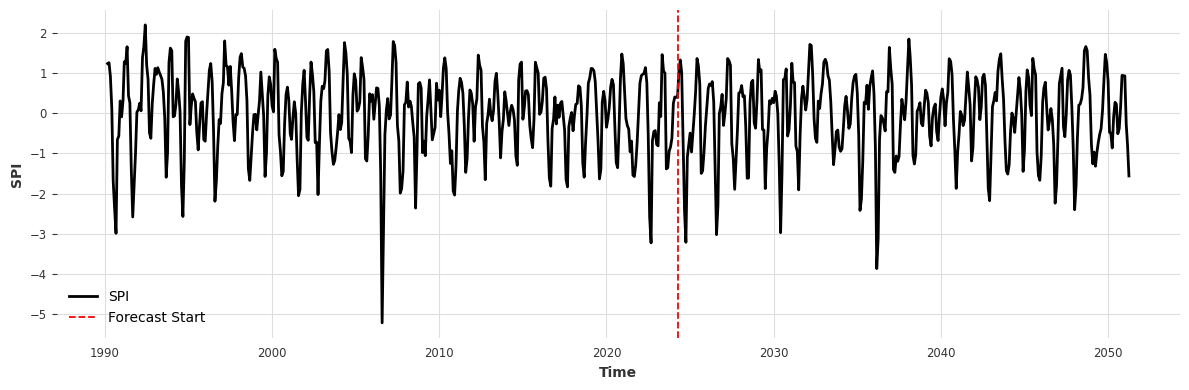

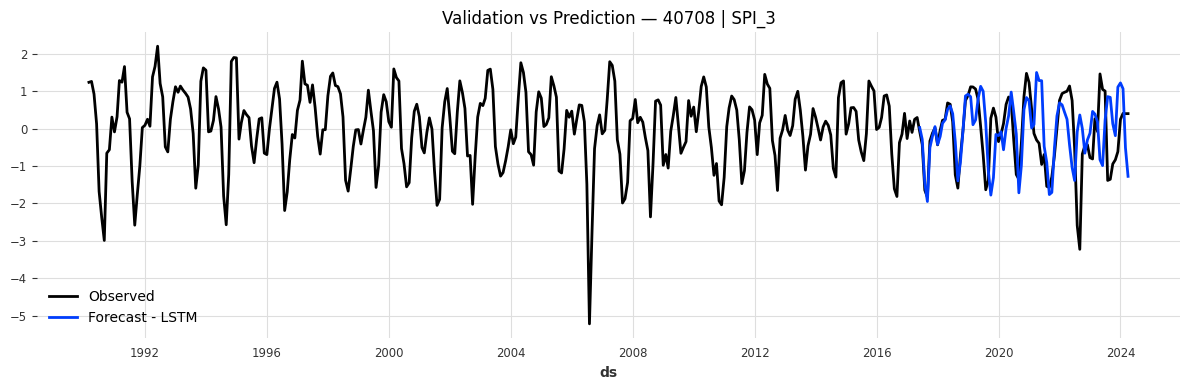

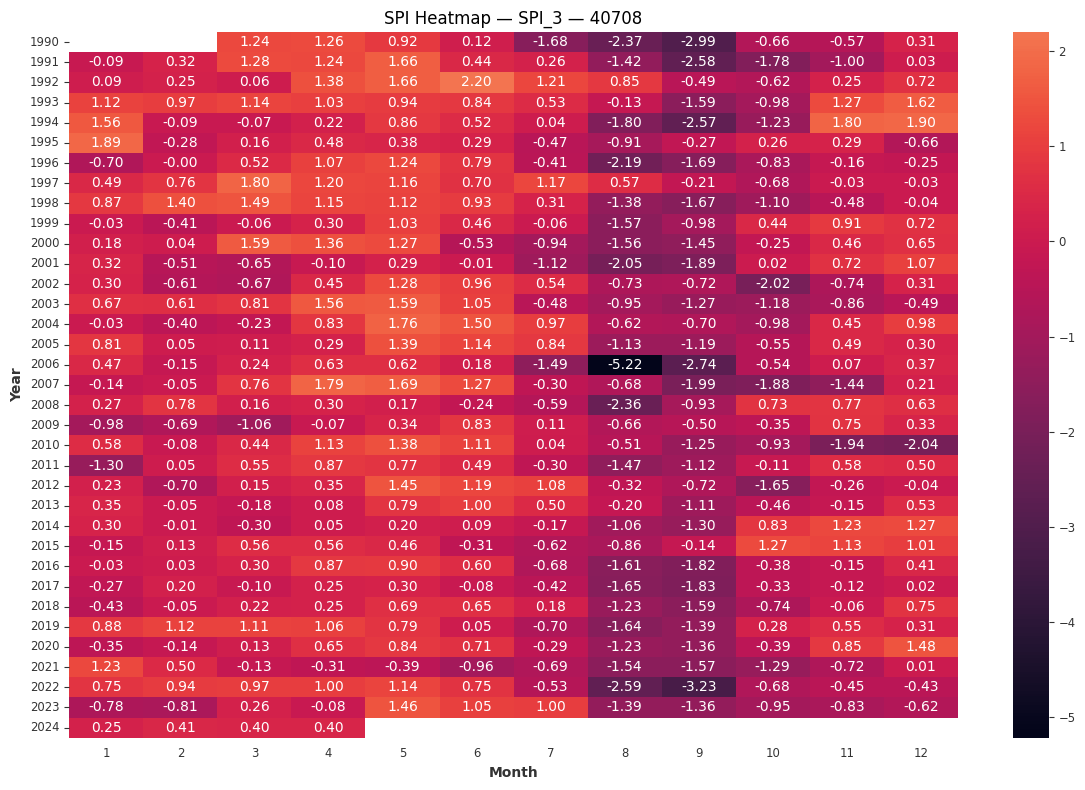

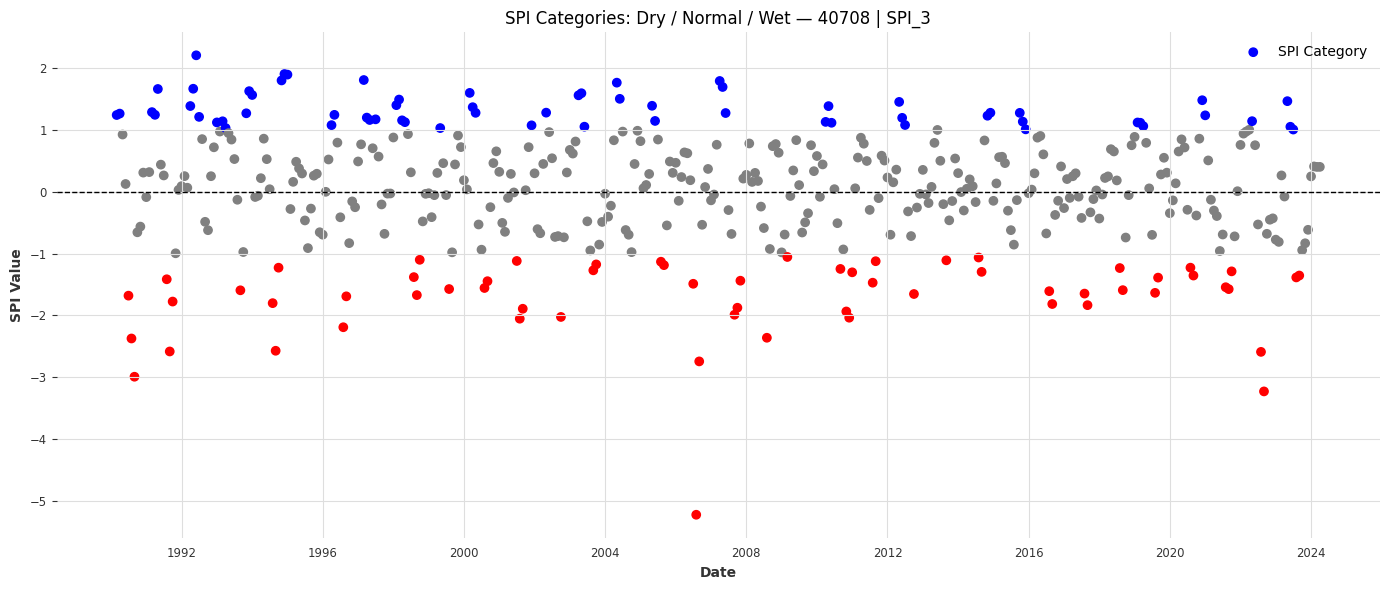

✔️ Done with 40708 | SPI_3



In [ ]:
for station_id, group in all_spi.groupby('station_id'):
        if station_id !=40708:
             continue
        for col in [c for c in group.columns if c.startswith("SPI_")]:
            if col != "SPI_3":
                continue
            model_stats = results[station_id][col]  
            sub_df = group[['ds', col]].dropna()

            series = TimeSeries.from_dataframe(sub_df, time_col='ds', value_cols=col)


            # Taylor Diagram
            ref_std = list(model_stats.values())[0][0]
            fig = plt.figure(figsize=(6, 6))
            taylor = TaylorDiagram(ref_std, fig, label='Observed')
            for name, (std_o, std_p, corr, rmse) in model_stats.items():
                taylor.add_sample(std_p, corr, label=name)
            taylor.add_contours(levels=5, colors='0.5')
            plt.legend()
            plt.title(f"Taylor Diagram: Station {station_id} | {col}")
            plt.tight_layout()
            fig.savefig(os.path.join(base_dir, f"{station_id}/taylor_{col}.png"))
            # plt.close()
            plt.show()

            # Best model
            best_model = min(model_stats.items(), key=lambda x: x[1][3])[0]
            # best_model = 'LSTM'
            print(f"Best model for {station_id} | {col}: {best_model}")
            best = model_constructors[best_model]()
            best.fit(series)
            # model_file = os.path.join(model_folder, f"{best_model}")
            # model_folder = os.path.join(base_dir, f"{station_id}/{col}")

            # model_file = os.path.join(model_folder, best_model)

            # if os.path.exists(model_file):
            #     print(f"Model {name} already trained. Skipping.")
                # model = load(model_file)
            # model_class = {
            #     'LSTM': RNNModel
            #     # ,
            #     # 'SVR': RegressionModel,
            #     # 'RandomRF': RandomForest,
            #     # 'ExtraTF': XGBModel,
            #     # 'WBBLSTM': WBBLSTMModel
            # }[best_model]
            # best = model_class.load(model_file)

            # Forecast to 2050
            horizon = (pd.Timestamp("2050-12-01") - series.end_time()).days // 30
            future = best.predict(horizon)


            if not isinstance(future.time_index, pd.DatetimeIndex):
                future = TimeSeries.from_times_and_values(
                    pd.date_range(
                        start=series.end_time() + pd.DateOffset(months=1),
                        periods=len(future),
                        freq="MS"
                    ),
                    future.values(),
                    columns=series.components
                )

            historical = series
            full_series = historical.append(future)

            plt.figure(figsize=(12, 4))
            full_series.plot(label="SPI")
            plt.axvline(x=historical.end_time(), color='r', linestyle='--', label="Forecast Start")
            # plt.title(title)
            plt.xlabel("Time")
            plt.ylabel("SPI")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()

            # Plot val vs forecast
            pred = forecasts[best_model]
            plt.figure(figsize=(12, 4))
            series.plot(label="Observed")
            pred.plot(label=f"Forecast - {best_model}")
            plt.title(f"Validation vs Prediction — {station_id} | {col}")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.savefig(os.path.join(base_dir, f"{station_id}/val_vs_pred_{col}.png"))
            plt.show()

            # Prepare SPI dataframe for heatmap + category
            spi_series = sub_df.copy()
            spi_series['year'] = pd.to_datetime(spi_series['ds']).dt.year
            spi_series['month'] = pd.to_datetime(spi_series['ds']).dt.month

            # SPI heatmap
            heatmap_data = spi_series.pivot_table(index='year', columns='month', values=col)
            plt.figure(figsize=(12, 8))
            sns.heatmap(heatmap_data, cmap='rocket', center=0, annot=True, fmt=".2f")
            plt.title(f"SPI Heatmap — {col} — {station_id}")
            plt.xlabel("Month")
            plt.ylabel("Year")
            plt.tight_layout()
            plt.grid(False)
            plt.savefig(os.path.join(base_dir, f"{station_id}/heatmap_{col}.png"))
            plt.show()

            # Categorical SPI scatter
            spi_series['category'] = pd.cut(spi_series[col], bins=[-np.inf, -1, 1, np.inf], labels=['Dry', 'Normal', 'Wet'])
            colors = {'Dry': 'red', 'Normal': 'gray', 'Wet': 'blue'}

            plt.figure(figsize=(14, 6))
            plt.scatter(spi_series['ds'], spi_series[col], c=spi_series['category'].map(colors), label='SPI Category')
            plt.axhline(0, color='black', lw=1, linestyle='--')
            plt.title(f"SPI Categories: Dry / Normal / Wet — {station_id} | {col}")
            plt.xlabel("Date")
            plt.ylabel("SPI Value")
            plt.grid(True)
            plt.tight_layout()
            plt.legend()
            plt.savefig(os.path.join(base_dir, f"{station_id}/scatter_{col}.png"))
            plt.show()

            print(f"✔️ Done with {station_id} | {col}\n")
